#5 - Notebook that implements a Naive Bayes Model using Bag of Words

---

### **This notebook primarily contains code that implements a Naive Bayes model using Bag of Words (an NLP technique) and the dataset that was created in the previous notebook.**
---

In this model, any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. Hence, it is known as "bag" of words.

```
Example:

"John likes to watch movies. Mary likes movies too."

After tokenization: "John","likes","to","watch","movies","Mary","likes","movies","too"

BoW = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};
```
The Naive Bayes classifier then predicts the tag of a text by calculating the probability of each tag for a given text and then outputs the tag with the highest one. 


---
# Importing libraries and defining constants

In [27]:
# Imports all the libraries required for the notebook to run.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from google.colab import drive
%matplotlib inline

In [2]:
# Mounts Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Sets the path for the data directory and the filenames.
DATA_PATH = "/content/drive/MyDrive/Data/"
PRE_PROCESSED_DATA_FILE_NAME = 'kaggle_newsdataset_preprocessed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

# Loading the dataset

In [4]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [5]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [6]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


# Split the data

In [7]:
y = df.label
X = df.drop('label', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [9]:
X_train.shape

(30910, 4)

In [10]:
X_test.shape

(7728, 4)

# Encode the labels

In [11]:
le = LabelEncoder()

In [12]:
y_train_enc = le.fit_transform(y_train)

In [13]:
y_test_enc = le.transform(y_test)

# Train the models

### Helper Functions

In [14]:
def passthrough(doc):
    # Passthrough function for use in the pipeline in case the text is already tokenized.
    return doc

In [15]:
def confustion_matrix_and_classification_report(estimator, X, y, labels, set_name):
    
    # Displays a classfication report and confusion matrix for a given input data.
    predictions = estimator.predict(X)

    print(f'Classification report for {set_name} set')
    print(classification_report(y, predictions, target_names=labels))

    matrix = plot_confusion_matrix(estimator,
                                   X,
                                   y,
                                   display_labels = labels,
                                   cmap = plt.cm.Blues,
                                   xticks_rotation = 70,
                                   values_format = 'd')
    matrix.ax_.set_title(f'{set_name} set confustion matrix, without normalization')

    plt.show()

    matrix = plot_confusion_matrix(estimator,
                                   X,
                                   y,
                                   display_labels = labels,
                                   cmap = plt.cm.Blues,
                                   xticks_rotation = 70,
                                   normalize = 'true')
    matrix.ax_.set_title(f'{set_name} set confustion matrix, with normalization')

    plt.show()

In [16]:
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc]

In [17]:
def remove_stopwords(doc):
    # Removes the stopwords from an input document.
    stop_words = stopwords.words('english')
    return [token for token in doc if ((token not in stop_words) and (token.lower() not in stop_words))]

In [18]:
def lowercase_tokens(doc):
    # Turns all letters provided in an input to lowercase.
    return [token.lower() for token in doc]

In [19]:
def lowercase_and_remove_stopwords(doc):
    # Removes stopwords and lowercase tokens from provided input data.
    stop_words = stopwords.words('english')
    return [token.lower() for token in doc if token.lower() not in stop_words]

In [20]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, stopwords, max_df=1.0, ngram_range = (1, 1)):
    
    # Trains and evaluates a bag of words representation with a naive bayes classifier.
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           stop_words = stopwords,
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),  
    ('classifier', MultinomialNB()),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    fake_class_prob_sorted = pipeline['classifier'].feature_log_prob_[0, :].argsort()
    true_class_prob_sorted = pipeline['classifier'].feature_log_prob_[1, :].argsort()
    
    print('fake ', np.take(pipeline['bow'].get_feature_names(), fake_class_prob_sorted[::-1][:25]))
    print('')
    print('true ', np.take(pipeline['bow'].get_feature_names(), true_class_prob_sorted[::-1][:25]))
    

## title only

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.96      0.96      0.96     13957
        true       0.97      0.97      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.97      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


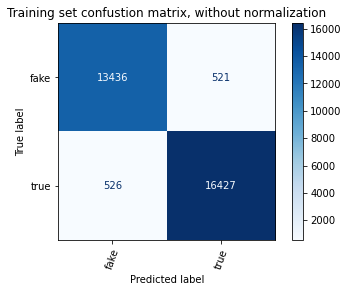

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


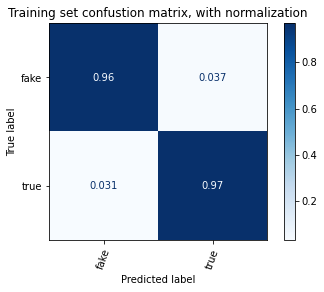

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.96      0.96      0.96      3490
        true       0.96      0.96      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


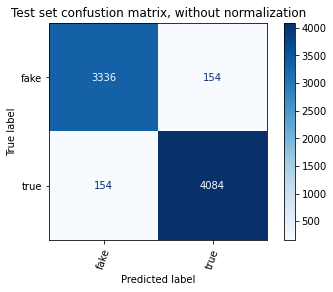

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


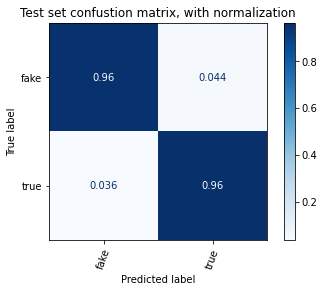

fake  ['trump' 'to' 'the' 'VIDEO' 'for' 'of' 'in' 'and' 'on' '!' 'is' 'video'
 'with' 'his' 'WATCH' 'he' 'about' 'obama' 'just' 'after' 'it' 'hillary'
 'at' 'by' 'from']

true  ['to' 'trump' 'in' 'U.S.' 'on' 'of' 'says' 'for' 'with' 'house' 'as'
 'after' 'over' 'north' 'russia' 'korea' 'at' 'white' 'new' 'from' 'not'
 'senate' 'china' 'will' 'court']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
train_and_eval_model(X_train['clean_title_tokens'], X_test['clean_title_tokens'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, None)

This model has high accuracy and F1 scores, but focusing on only the title may be too limiting.  Therefore, we should try and look at the text in addition to the title.

## text only

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.96     13957
        true       0.97      0.96      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


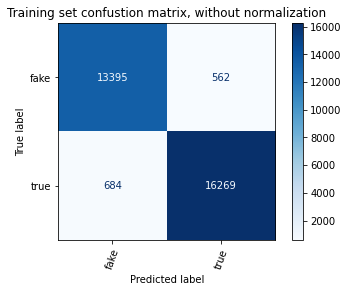

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


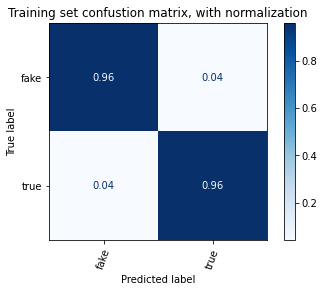

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.94      3490
        true       0.96      0.95      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


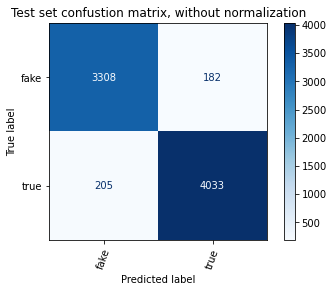

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


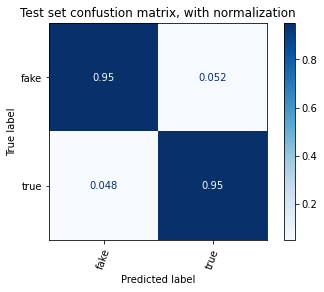

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'he' 'it' 'on' 'was'
 'with' 'his' 'this' 'as' 'be' 'not' 'are' 'they' 'have' 'i' 'by' 'has']

true  ['the' 'to' 'of' 'and' 'in' 'on' 'said' 'that' 'for' 'is' 'trump' 'with'
 'he' 'it' 'was' 'by' 'as' 'has' 'from' 'U.S.' 'his' 'not' 'have' 'be'
 'at']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
train_and_eval_model(X_train['clean_text_tokens'], X_test['clean_text_tokens'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, None)

Text only did a little worse than just the title.  It seems as if the title holds a lot of information.

## title and text

In [23]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']

In [24]:
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96     13957
        true       0.97      0.96      0.97     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


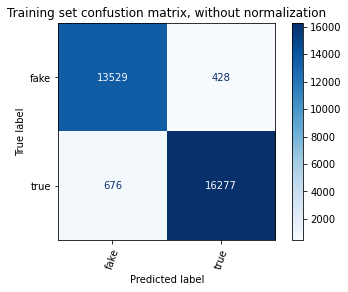

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


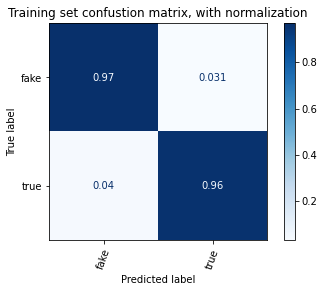

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95      3490
        true       0.96      0.95      0.96      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


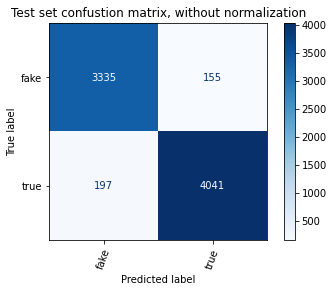

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


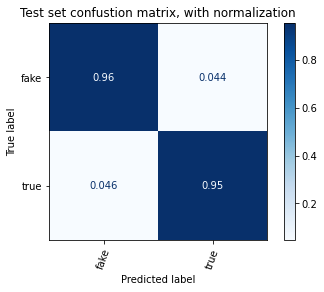

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'he' 'it' 'on' 'was'
 'with' 'his' 'this' 'as' 'be' 'are' 'not' 'they' 'have' 'i' 'by' 'has']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'trump' 'with' 'is'
 'he' 'it' 'as' 'by' 'was' 'has' 'U.S.' 'from' 'not' 'his' 'have' 'be'
 'at']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, None)

Text and title combined did the same as just text, but slightly worse than just title.  The slight bit of additional information in the title probably got lost because of the length of the story vs. the title.

## title and text with lemmatization

In [30]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96     13957
        true       0.97      0.96      0.97     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


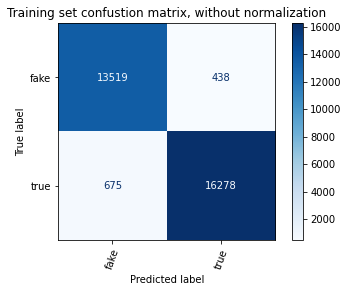

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


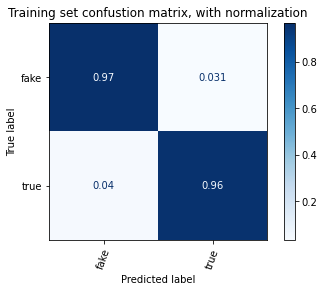

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.95      3490
        true       0.96      0.95      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


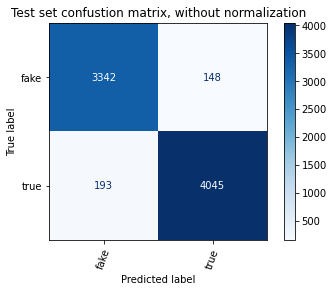

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


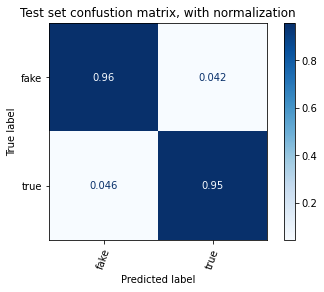

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'it' 'he' 'on' 'wa'
 'with' 'his' 'this' 'a' 'be' 'are' 'not' 'they' 'have' 'i' 'by' 'ha']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'it' 'trump' 'with'
 'is' 'he' 'a' 'by' 'wa' 'ha' 'U.S.' 'from' 'not' 'his' 'state' 'have'
 'be']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, LemmaTokenizer(), None)

By adding lemmatization, the accuracy and F1 scores start to match the performance of the model using just the title.

## text and title with stopwords removed

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


Classification report for Training set
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96     13957
        true       0.98      0.96      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.96      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


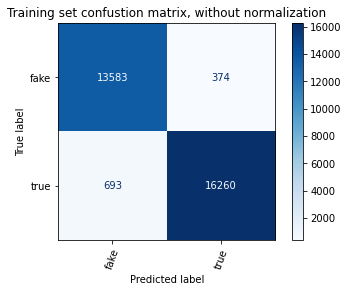

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


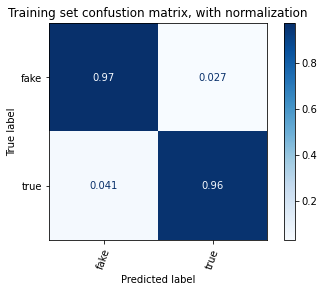

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95      3490
        true       0.97      0.95      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


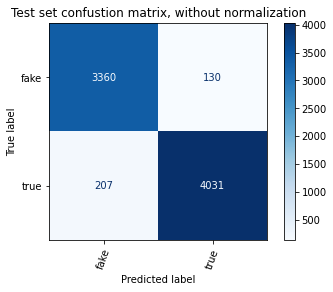

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


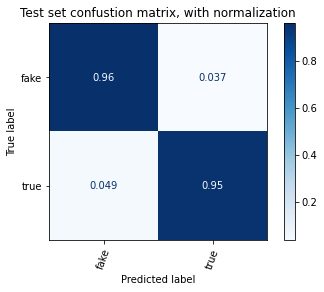

fake  ['trump' 'said' 'people' 'twitter-handle' 'president' 'would' 'one'
 'donald' '!' 'like' 'obama' 'clinton' 'also' 'even' 'new' 'white'
 'hillary' 'via' 'time' 'news' 'image' 'state' 'link' 'get' 'campaign']

true  ['said' 'trump' 'U.S.' 'would' 'president' 'state' 'government' 'house'
 'states' 'new' 'republican' 'also' 'united' 'people' 'told' 'could' 'one'
 'party' 'last' 'election' 'two' 'year' 'former' 'campaign' 'north']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, stopwords.words('english'))

Removing the stopwords doesn't look to have any significant effect.

## title with stopwords removed

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.96      0.95      0.96     13957
        true       0.96      0.96      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


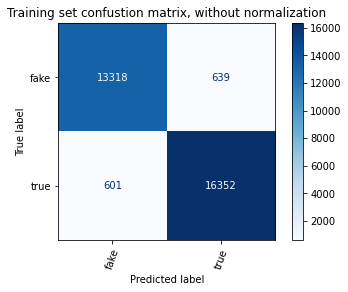

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


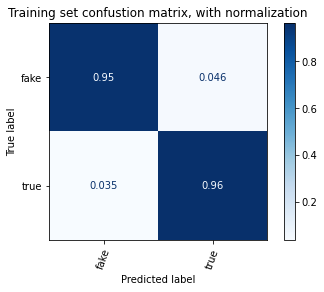

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.95      0.94      0.95      3490
        true       0.95      0.96      0.96      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


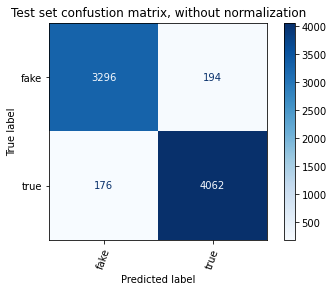

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


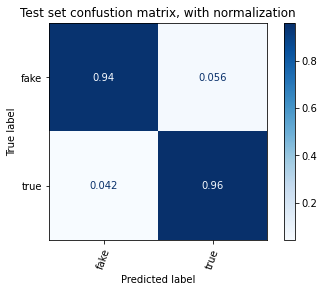

fake  ['trump' 'VIDEO' '!' 'video' 'WATCH' 'obama' 'hillary' 'GOP' 'donald'
 'president' 'TRUMP' 'white' 'clinton' 'BREAKING' 'new' 'news' 'black'
 'OBAMA' 'gets' 'TWEETS' 'says' 'one' 'republicans' 'HILLARY' 'republican']

true  ['trump' 'U.S.' 'says' 'house' 'north' 'russia' 'korea' 'white' 'new'
 'senate' 'china' 'court' 'bill' 'obama' 'republican' 'clinton' 'state'
 'tax' 'deal' 'vote' 'talks' 'election' 'EU' 'president' 'iran']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = passthrough, 
                     tokenizer = remove_stopwords, 
                     stopwords = None, 
                     max_df = 1.0)

Removing the stopwords from the title reduced its accuracy. We should try and set all characters to lowercase and check the result.

## title only, stopwords removed & all characters set to lowercase

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.95     13957
        true       0.96      0.95      0.95     16953

    accuracy                           0.95     30910
   macro avg       0.95      0.95      0.95     30910
weighted avg       0.95      0.95      0.95     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


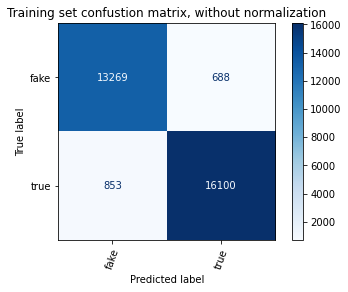

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


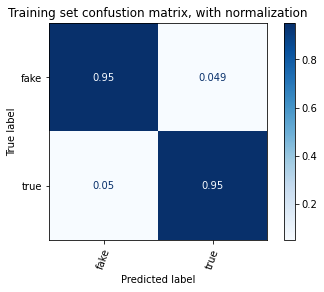

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      3490
        true       0.95      0.94      0.94      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


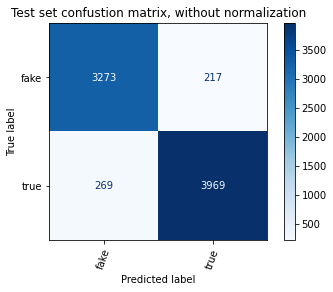

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


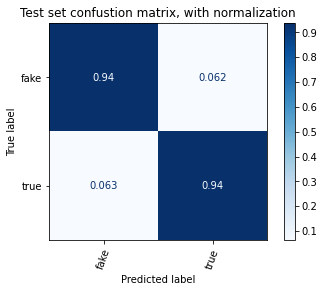

fake  ['trump' 'video' '!' 'obama' 'watch' 'hillary' 'president' 'clinton' 'gop'
 'donald' 'new' 'news' 'white' 'black' 'breaking' 'tweets' 'gets' 'one'
 'america' 'bill' 'media' 'says' 'muslim' 'house' 'republicans']

true  ['trump' 'u.s.' 'says' 'house' 'north' 'russia' 'korea' 'white' 'new'
 'senate' 'china' 'court' 'bill' 'obama' 'republican' 'clinton' 'state'
 'tax' 'deal' 'eu' 'vote' 'talks' 'election' 'president' 'iran']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = lowercase_tokens, 
                     tokenizer = remove_stopwords, 
                     stopwords = None, 
                     max_df = 1.0)

The accuracy went down again, although just a little.  The words with all capitals must have contained some information that was useful to the classifier.  We need to decide if that information is useful when looking at outside data.

## title only, n-gram range - [1, 2]

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.95     13957
        true       0.96      0.95      0.96     16953

    accuracy                           0.95     30910
   macro avg       0.95      0.95      0.95     30910
weighted avg       0.95      0.95      0.95     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


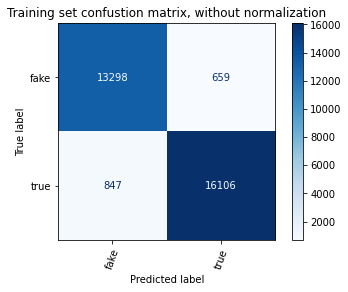

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


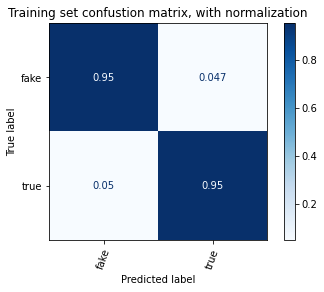

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      3490
        true       0.95      0.94      0.94      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


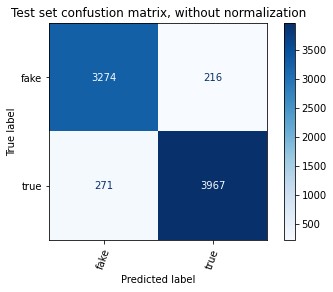

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


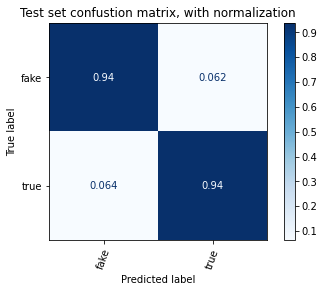

fake  ['trump' 'video' '!' 'obama' 'watch' 'hillary' 'republican' 'tweet'
 'president' 'clinton' 'get' 'gop' 'donald' 'donald trump' 'black' 'white'
 'new' 'news' 'say' 'breaking' 'make' 'woman' 'muslim' 'go' 'one']

true  ['trump' 'u.s.' 'say' 'house' 'republican' 'north' 'russia' 'korea'
 'white' 'new' 'white house' 'state' 'senate' 'china' 'court' 'bill'
 'north korea' 'obama' 'tax' 'clinton' 'vote' 'deal' 'talk' 'leader'
 'call']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = lowercase_and_remove_stopwords, 
                     tokenizer = LemmaTokenizer(), 
                     stopwords = None, 
                     max_df = 1.0,
                     ngram_range = (1, 2))

Using 1 and 2 word n-grams seems to have little effect on the model.

## title and text, lowercase & lemmatize

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.95     13957
        true       0.97      0.96      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


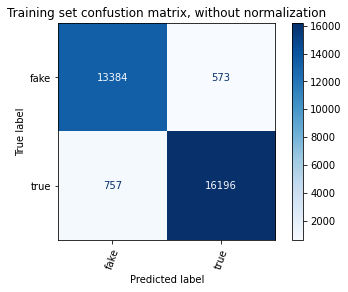

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


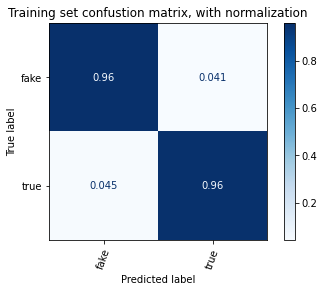

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.94      3490
        true       0.96      0.95      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


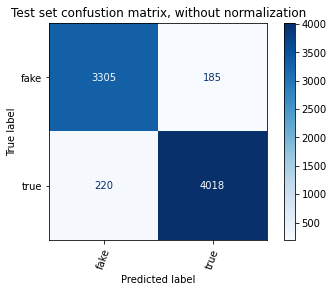

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


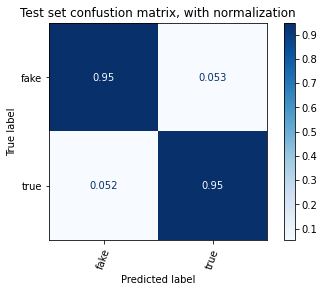

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'it' 'he' 'on' 'wa'
 'with' 'his' 'this' 'a' 'be' 'not' 'are' 'they' 'have' 'by' 'i' 'ha']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'it' 'trump' 'with'
 'is' 'he' 'a' 'by' 'wa' 'ha' 'u.s.' 'from' 'not' 'his' 'state' 'have'
 'be']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, lowercase_tokens, LemmaTokenizer(), None)

Again, there is little effect to note.

## title and text, lowercase, lemmatize & no stopwords

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95     13957
        true       0.97      0.95      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


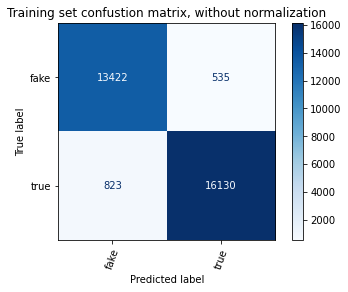

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


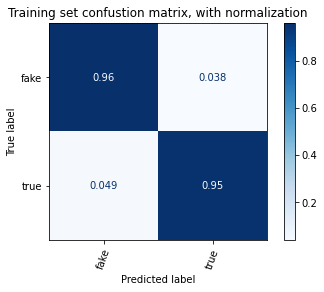

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.93      0.95      0.94      3490
        true       0.96      0.95      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


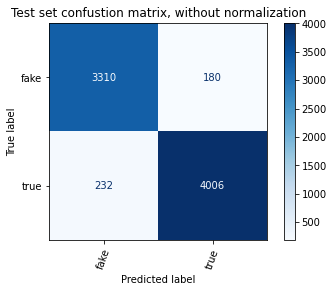

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


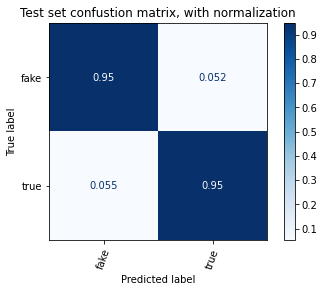

fake  ['trump' 'said' 'people' 'twitter-handle' 'president' 'one' 'would'
 'state' 'donald' 'republican' 'like' '!' 'obama' 'clinton' 'image' 'time'
 'video' 'say' 'american' 'also' 'even' 'year' 'white' 'new' 'hillary']

true  ['said' 'trump' 'u.s.' 'state' 'would' 'president' 'republican'
 'government' 'year' 'house' 'new' 'also' 'united' 'party' 'people'
 'official' 'election' 'told' 'country' 'could' 'one' 'say' 'washington'
 'last' 'two']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, lowercase_and_remove_stopwords, LemmaTokenizer(), None)

## title and text, lowercase, lemmatize, no stopwords & n-grams - [1,2]

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.97      0.98      0.97     13957
        true       0.98      0.97      0.98     16953

    accuracy                           0.98     30910
   macro avg       0.97      0.98      0.97     30910
weighted avg       0.98      0.98      0.98     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


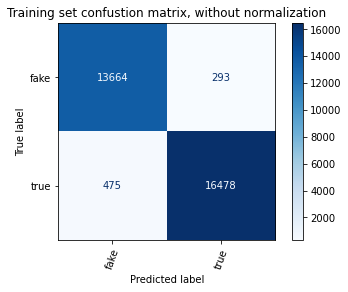

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


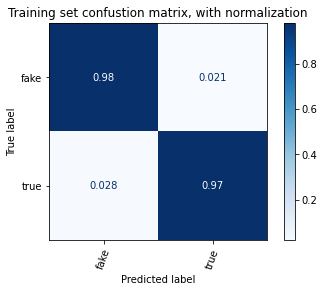

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.96      3490
        true       0.97      0.96      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


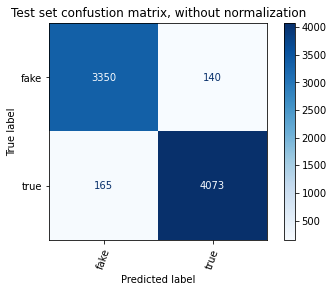

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


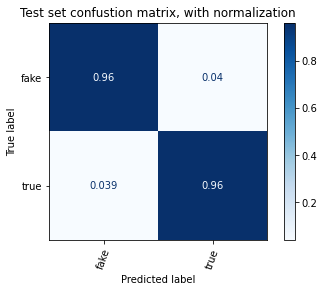

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


fake  ['trump' 'said' 'people' 'twitter-handle' 'president' 'one' 'would'
 'state' 'donald' 'republican' 'like' '!' 'obama' 'clinton' 'image' 'time'
 'video' 'say' 'donald trump' 'american' 'also' 'even' 'year' 'white'
 'new']

true  ['said' 'trump' 'u.s.' 'state' 'would' 'president' 'republican'
 'government' 'year' 'house' 'new' 'also' 'united' 'party' 'people'
 'official' 'election' 'told' 'country' 'could' 'one' 'say' 'washington'
 'last' 'united state']


In [40]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, 
                     lowercase_and_remove_stopwords, LemmaTokenizer(), None,
                     ngram_range = (1, 2))

None of the above models returned performance metrics that changed much.  They would go up or down by a point or two, but were all around 0.95.

## title and text, lowercase & only stopwords

We should try looking into using only stopwords.  A lot of information will be lost, but the model may be more generalizable if the performance is still good.

In [41]:
def lowercase_and_only_stopwords(doc):
    # Removes stopwords and lowercase tokens.
    stop_words = stopwords.words('english')
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.87      0.80      0.84     13957
        true       0.85      0.91      0.88     16953

    accuracy                           0.86     30910
   macro avg       0.86      0.85      0.86     30910
weighted avg       0.86      0.86      0.86     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


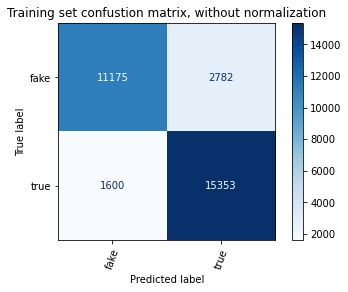

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


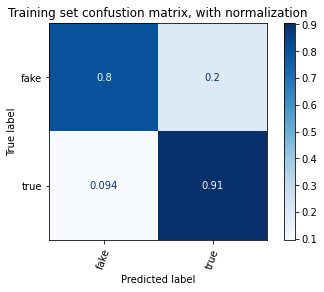

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.87      0.79      0.83      3490
        true       0.84      0.90      0.87      4238

    accuracy                           0.85      7728
   macro avg       0.86      0.85      0.85      7728
weighted avg       0.85      0.85      0.85      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


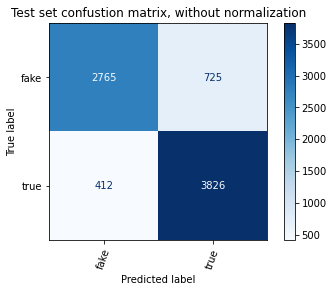

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


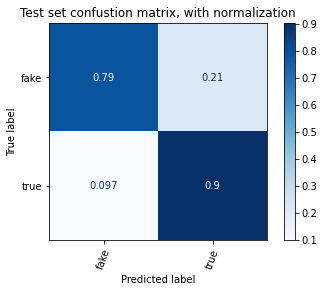

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'he' 'it' 'on' 'was' 'with'
 'his' 'this' 'as' 'be' 'not' 'are' 'they' 'have' 'by' 'i' 'you' 'has']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'that' 'for' 'with' 'is' 'he' 'it' 'as'
 'by' 'was' 'has' 'from' 'not' 'his' 'have' 'be' 'at' 'an' 'who' 'but']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, 
                     lowercase_and_only_stopwords, passthrough, None)

The accuracy dropped by 10 points, which is quite a bit.  We should try using a larger set of stopwords.

## title and text, lowercase, only expanded stopwords

In [43]:
# The below code uses an expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

In [44]:
def lowercase_and_only_expanded_stopwords(doc):
    # Removes stopwords and lowercase tokens.
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.93      0.88      0.91     13957
        true       0.90      0.95      0.93     16953

    accuracy                           0.92     30910
   macro avg       0.92      0.91      0.92     30910
weighted avg       0.92      0.92      0.92     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


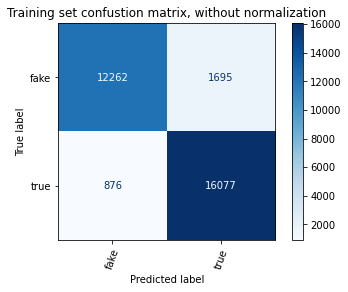

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


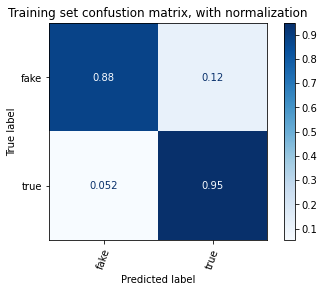

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.94      0.86      0.90      3490
        true       0.89      0.95      0.92      4238

    accuracy                           0.91      7728
   macro avg       0.91      0.91      0.91      7728
weighted avg       0.91      0.91      0.91      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


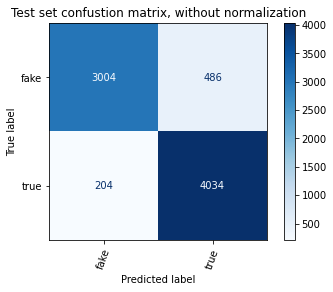

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


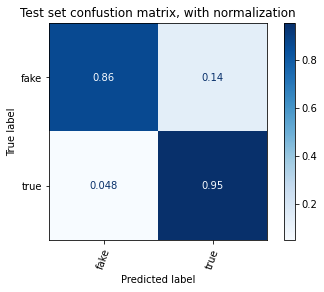

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'he' 'it' 'on' 'was' 'with'
 'his' 'this' 'as' 'be' 'not' 'are' 'they' 'have' 'by' 'i' 'you' 'has']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'with' 'is' 'he' 'it'
 'as' 'by' 'was' 'has' 'from' 'not' 'his' 'have' 'be' 'at' 'an' 'would']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, 
                     lowercase_and_only_expanded_stopwords, passthrough, None)

With this model, the accuracy and F1 scores are back up into the 90's range.

---
# **Summary**

While the models that used the stopwords plus the other words in the text performed somewhat better, (around 0.05 to 0.06 points higher to be specific), the model with just the stopwords should generalize better and be more useful when using the model on news stories from outside the dataset.